# CSML1020 Machine Learning at Scale Project
## Birdsong Classifier
### Pete Gray YorkU# 217653247 ptgray@my.yorku.ca

For an initial exploration of the audio files, and features that can be observed within them, code is adapted from https://www.kaggle.com/ashishpatel26/feature-extraction-from-audio

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Load an audio file

In [2]:
import librosa
audio_path = 'data/train_set/train_set/train_aegithalos_caudatus.wav'
x , sr = librosa.load(audio_path)


### Test file and loading by playing a file

In [3]:
import IPython.display as ipd
ipd.Audio(audio_path)

### Show Waveform

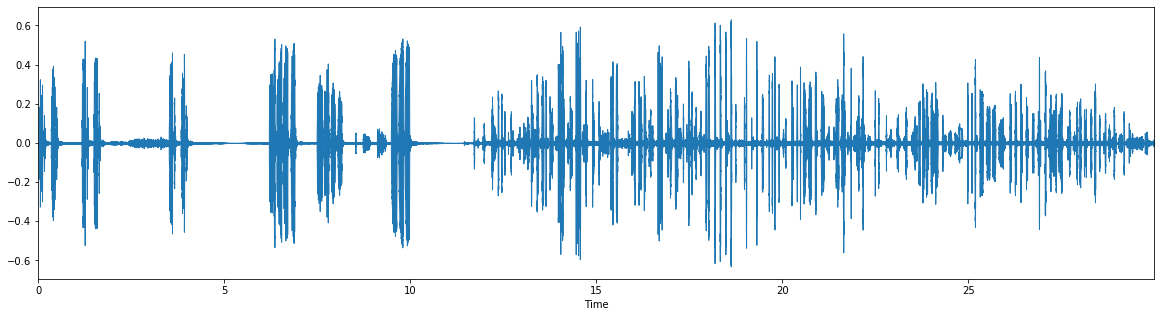

In [4]:
%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(20, 5))
librosa.display.waveplot(x, sr=sr)

### Display Spectrogram

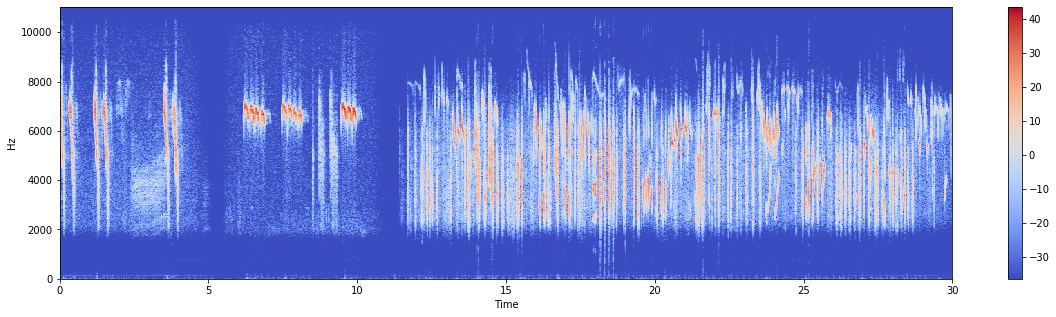

In [5]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

### Log frequency axis

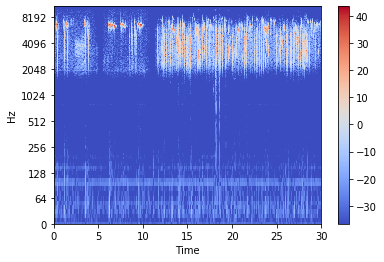

In [6]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

### Creating and Audio Signal
Making a Numpy thing out of the audio file

In [7]:
#import numpy as np
#sr = 22050 # sample rate
#T = 5.0    # seconds
#t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
#x = 0.5*np.sin(2*np.pi*220*t)# pure sine wave at 220 Hz

In [8]:
ipd.Audio(x, rate=sr) # load a NumPy array

### Save the signal

In [9]:
#librosa.output.write_wav('data/tone_440.wav', x, sr) # writing wave file in tone440.wav format

### Zero Crossing Rate

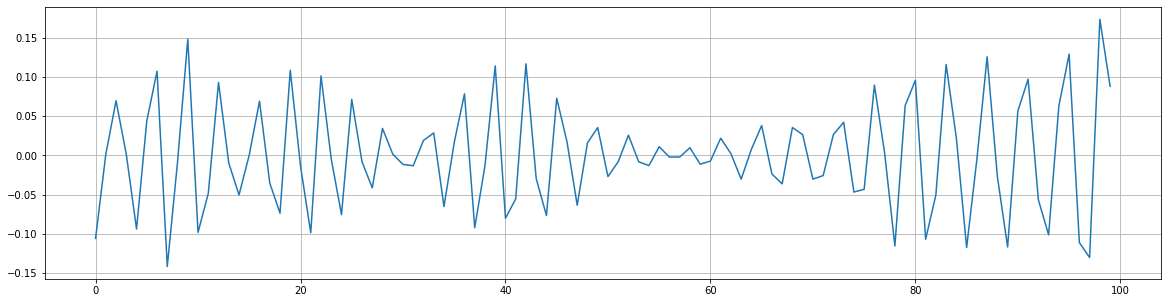

In [10]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(20, 5))
plt.plot(x[n0:n1])
plt.grid()

In [11]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
zero_crossings.shape

(100,)

In [12]:
print(sum(zero_crossings))

57


### Spectral Centroids

In [13]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape

(1292,)

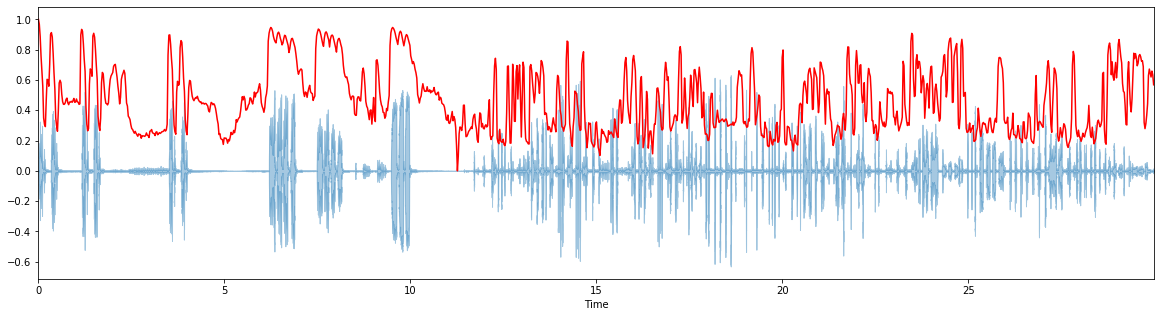

In [14]:
# Computing the time variable for visualization
plt.figure(figsize=(20,5))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

### Spectral Rolloff

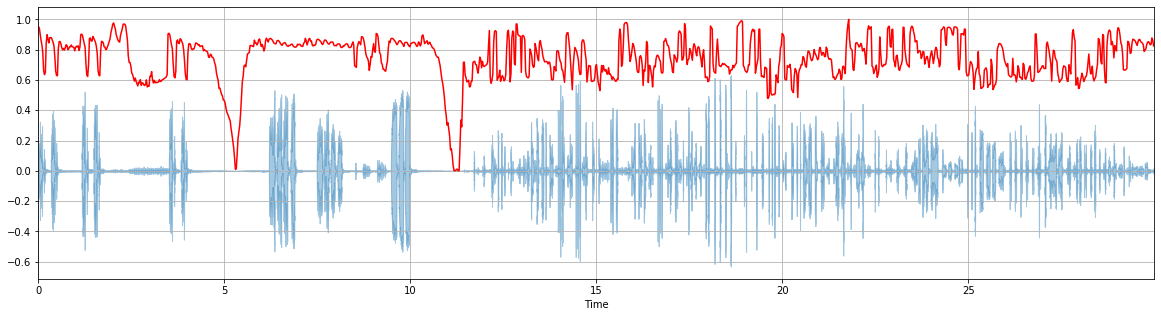

In [15]:
plt.figure(figsize=(20,5))
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.grid()

### MFCC

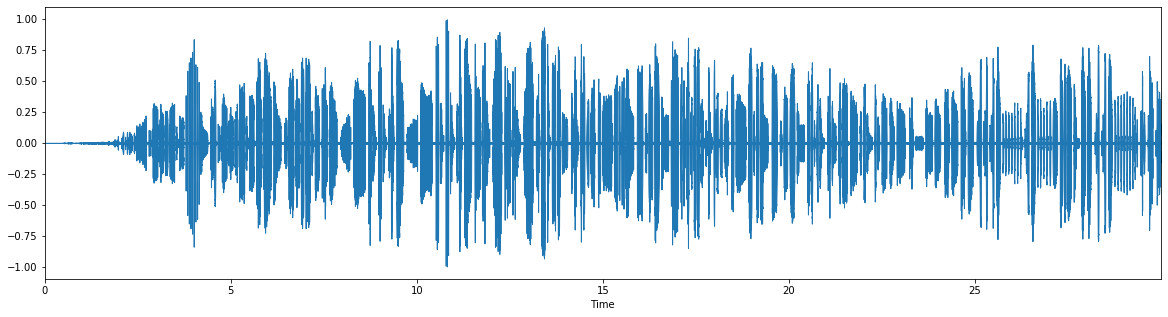

In [16]:
plt.figure(figsize=(20,5))
x, fs = librosa.load('data/train_set/train_set/train_alauda_arvensis.wav')
librosa.display.waveplot(x, sr=sr)

(20, 1292)


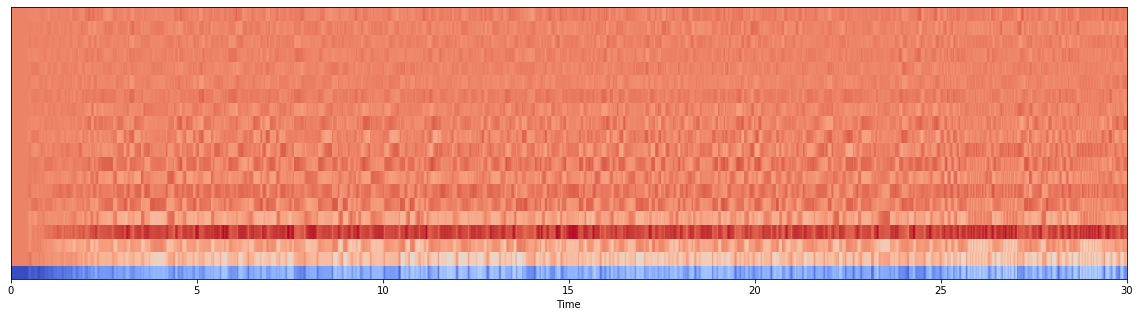

In [17]:
# MFCC
plt.figure(figsize=(20,5))
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### Feature Scaling

In [18]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))

[ 5.6098489e-08  2.7311106e-08 -4.8901643e-09  3.3954350e-08
  4.0078589e-09 -1.0979803e-08  1.6349324e-08  1.0610734e-08
 -1.4485958e-08  2.3597350e-08  7.1045783e-09 -8.6731218e-09
  1.4578226e-08 -1.9376122e-08  6.2741732e-09 -2.6296167e-09
 -3.7829575e-09  1.8822519e-08  9.8725961e-09 -7.1507120e-09]
[1.         1.0000013  1.0000001  1.0000004  0.9999992  1.0000006
 1.0000002  0.9999997  1.0000006  0.9999999  0.9999994  1.000001
 0.99999857 0.99999964 0.9999997  1.0000004  1.0000006  1.0000002
 0.99999964 0.9999992 ]


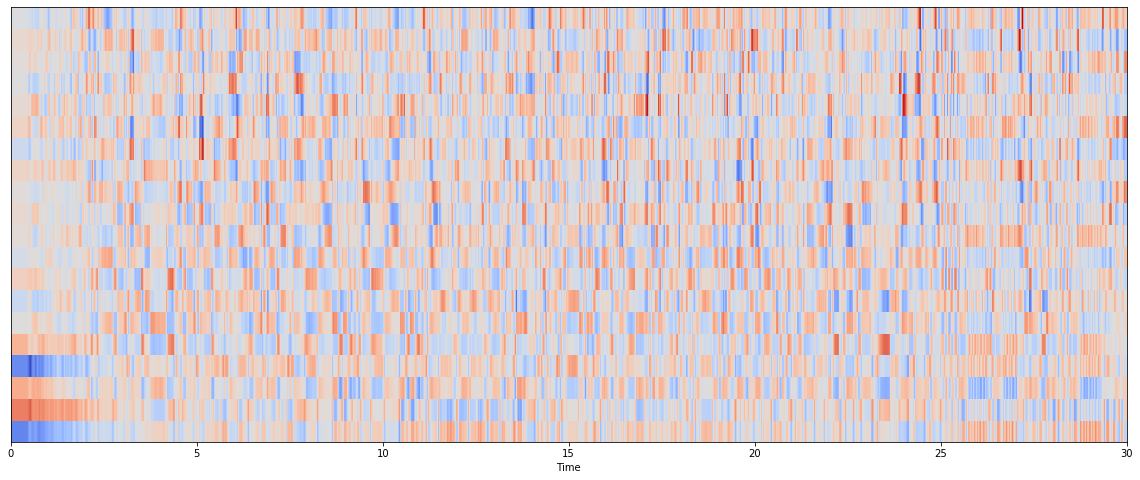

In [19]:
plt.figure(figsize=(20,8))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### Chroma Frequencies

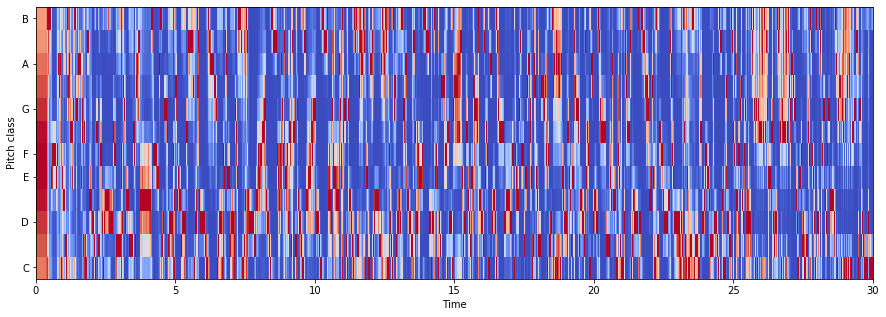

In [20]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

# Using a CNN for audio classification

Using code adapted from https://medium.com/gradientcrescent/urban-sound-classification-using-convolutional-neural-networks-with-keras-theory-and-486e92785df4

In [23]:
%matplotlib inline
import memory_profiler
from memory_profiler import memory_usage
import os
import pandas as pd
from glob import glob
import numpy as np

In [24]:
from keras import layers
from keras import models
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
from path import Path

Using TensorFlow backend.


In [165]:
def create_spectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    #print("audio file loaded")
    fig = plt.figure(figsize=[0.72,0.72])
    # plt.plot(x[1000:5000])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = 'data/specs/' + name + '.jpg'
    #print(filename)
    print(name)
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    #del filename,name,clip,sample_rate,fig,ax,S

In [166]:
def create_spectrogram_test(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = Path('data/specs_test/' + name + '.jpg')
    fig.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [167]:
Data_dir=np.array(glob("data/train/*"))

In [168]:
for file in Data_dir[0:30]:
    #Define the filename as is, "name" refers to the JPG, and is split off into the number itself. 
    #filename,name = file,file.split('/')[-1].split('.')[0]
    #print(file)
    filename,name = file,file.split('\\')[-1].split('.')[0]
    create_spectrogram(filename,name)

train_aegithalos_caudatus
train_alauda_arvensis
train_anthus_trivialis
train_branta_canadensis
train_carduelis_chloris
train_certhia_brachydactyla
train_columba_palumbus
train_corvus_corone
train_cuculus_canorus
train_dendrocopos_major
train_emberiza_citrinella
train_erithacus_rubecula
train_fringilla_coelebs
train_garrulus_glandarius
train_luscinia_megarhynchos
train_motacilla_alba
train_oriolus_oriolus
train_parus_caeruleus
train_parus_major
train_parus_palustris
train_pavo_cristatus
train_phasianus_colchicus
train_phoenicurus_phoenicurus
train_phylloscopus_collybita
train_picus_viridis
train_prunella_modularis
train_sitta_europaea
train_streptopelia_decaocto
train_strix_aluco
train_sturnus_vulgaris


In [169]:
Test_dir=np.array(glob("data/test/*"))
for file in Test_dir[0:30]:
    filename,name = file,file.split('\\')[-1].split('.')[0]
    create_spectrogram_test(filename,name)

In [103]:
from keras_preprocessing.image import ImageDataGenerator

In [170]:
def append_ext(fn):
    fn2=fn.split('.')[0]
    return fn2+".jpg"

In [230]:
#df.reset_index(drop=True)
traindf=pd.read_csv('data/species_numbers.csv',dtype=str)
#traindf.reset_index(drop=True)
testdf=pd.read_csv('data/test.csv',dtype=str)
#testdf.reset_index(drop=True)
#traindf["ID"]=traindf["ID"].apply(append_ext)
#testdf["ID"]=testdf["ID"].apply(append_ext)
traindf["ID"]=''
# file.split('.')[0]
# temp_name=traindf["training_sample"].split('.')[0]
traindf["ID"]=traindf["training_sample"].apply(append_ext)
testdf["ID"]=''
testdf["ID"]=testdf["clip"].apply(append_ext)
traindf.columns


Index(['species', 'training_sample', 'ID'], dtype='object')

In [232]:
#traindf
testdf

clip species                     ID
0     A_20090324_063100.wav       1  A_20090324_063100.jpg
1     A_20090324_063100.wav       2  A_20090324_063100.jpg
2     A_20090324_063100.wav       3  A_20090324_063100.jpg
3     A_20090324_063100.wav       4  A_20090324_063100.jpg
4     A_20090324_063100.wav       5  A_20090324_063100.jpg
...                     ...     ...                    ...
3145  C_20090522_044800.wav      31  C_20090522_044800.jpg
3146  C_20090522_044800.wav      32  C_20090522_044800.jpg
3147  C_20090522_044800.wav      33  C_20090522_044800.jpg
3148  C_20090522_044800.wav      34  C_20090522_044800.jpg
3149  C_20090522_044800.wav      35  C_20090522_044800.jpg

[3150 rows x 3 columns]

In [217]:
traindf = traindf.append(traindf)

In [218]:
traindf

species                    training_sample  \
0        1      train_aegithalos_caudatus.wav   
1        2          train_alauda_arvensis.wav   
2        3         train_anthus_trivialis.wav   
3        4        train_branta_canadensis.wav   
4        5        train_carduelis_chloris.wav   
..     ...                                ...   
30      31       train_sylvia_atricapilla.wav   
31      32  train_troglodytes_troglodytes.wav   
32      33            train_turdus_merula.wav   
33      34        train_turdus_philomelos.wav   
34      35        train_turdus_viscivorus.wav   

                                   ID  
0       train_aegithalos_caudatus.jpg  
1           train_alauda_arvensis.jpg  
2          train_anthus_trivialis.jpg  
3         train_branta_canadensis.jpg  
4         train_carduelis_chloris.jpg  
..                                ...  
30       train_sylvia_atricapilla.jpg  
31  train_troglodytes_troglodytes.jpg  
32            train_turdus_merula.jpg  
33        train_turdus_philomelos.jpg  
34        train_turdus_viscivorus.jpg  

[70 rows x 3 columns]

In [219]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [220]:
train_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="data/specs",
    x_col="ID",
    y_col="species",
    subset="training",
    batch_size=10,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    # target_size=(8,8))
    target_size=(64,64))

Found 44 validated image filenames belonging to 29 classes.


In [221]:
valid_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="data/specs",
    x_col="ID",
    y_col="species",
    subset="validation",
    batch_size=10,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

Found 14 validated image filenames belonging to 29 classes.


In [222]:
import tensorflow.keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
import pandas as pd
import numpy as np

In [223]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#model.add(Dense(10, activation='softmax'))
model.add(Dense(29, activation='softmax'))
model.compile(optimizers.RMSprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_88 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_89 (Activation)   (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 31, 31, 64)      

In [225]:
#Fitting keras model, no test gen for now
#STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TRAIN=10
STEP_SIZE_VALID=10
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)
model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID
)

Epoch 1/10
10/10 [==============================] - 15s 2s/step - loss: 1.5611 - accuracy: 0.6023 - val_loss: 1.5374 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 15s 2s/step - loss: 1.4041 - accuracy: 0.6591 - val_loss: 1.2531 - val_accuracy: 0.7857
Epoch 3/10
10/10 [==============================] - 15s 2s/step - loss: 1.0286 - accuracy: 0.7614 - val_loss: 0.6629 - val_accuracy: 0.7857
Epoch 4/10
10/10 [==============================] - 15s 2s/step - loss: 0.5239 - accuracy: 0.8636 - val_loss: 0.1722 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 15s 2s/step - loss: 0.6754 - accuracy: 0.8523 - val_loss: 0.2183 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 15s 2s/step - loss: 0.4285 - accuracy: 0.8750 - val_loss: 0.1481 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 16s 2s/step - loss: 0.2674 - accuracy: 0.9318 - val_loss: 0.1560 - val_accuracy: 0.9286
Epoch 8/10
10/10 [==

[0.0029305830132216213, 1.0]

In [233]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="data/specs_test",
    x_col="ID",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(64,64))
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
STEP_SIZE_TEST=10

Found 1050 validated image filenames.


In [236]:
testdf

clip species                     ID
0     A_20090324_063100.wav       1  A_20090324_063100.jpg
1     A_20090324_063100.wav       2  A_20090324_063100.jpg
2     A_20090324_063100.wav       3  A_20090324_063100.jpg
3     A_20090324_063100.wav       4  A_20090324_063100.jpg
4     A_20090324_063100.wav       5  A_20090324_063100.jpg
...                     ...     ...                    ...
3145  C_20090522_044800.wav      31  C_20090522_044800.jpg
3146  C_20090522_044800.wav      32  C_20090522_044800.jpg
3147  C_20090522_044800.wav      33  C_20090522_044800.jpg
3148  C_20090522_044800.wav      34  C_20090522_044800.jpg
3149  C_20090522_044800.wav      35  C_20090522_044800.jpg

[3150 rows x 3 columns]

In [239]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

#Fetch labels from train gen for testing
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(predictions[0:10])

10/10 [==============================] - 10s 979ms/step
['7', '7', '7', '7', '7', '7', '7', '7', '7', '7']


In [235]:
labels

{0: '1',
 1: '10',
 2: '11',
 3: '12',
 4: '13',
 5: '14',
 6: '15',
 7: '16',
 8: '17',
 9: '18',
 10: '19',
 11: '2',
 12: '20',
 13: '21',
 14: '22',
 15: '23',
 16: '24',
 17: '25',
 18: '26',
 19: '27',
 20: '28',
 21: '29',
 22: '3',
 23: '30',
 24: '4',
 25: '5',
 26: '6',
 27: '7',
 28: '9'}